# COVID-19 Factors Project

## Preprocessing

We will only look at the first 110 columns, and we will remove the state distance and normalized columns.

In [1]:
import pandas as pd
import numpy as np

# Import data
df = pd.read_csv('covid_data.csv')

# Preprocessing
# We will only look at the first 110 columns,
# and we will remove the state distance, normalized,
# infection and death score, age, demographic,
# lockdown type, area, and other categorical columns.
df = df.iloc[:,:111]
df = df.drop([col for col in df.columns if col[0] == 'd' or 'Norm' in col or 'Score' in col or 'age' in col], axis=1)

df = df.drop(['Death-Infected','Lockdown type','Population','area'],axis=1)
df = df.drop(['White','Asian','Black','Hispanic','Male','Female','Homeless'],axis=1)
df = df.set_index('State')
df = df.dropna()

## 1) Hypothesis Testing
Can it be broadly predicted whether the number of confirmed Covid-19 cases and the deaths are more in densely populated areas than in less-densely populated areas in the US?

In [2]:
# QUESTION 1

from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt

data = df[['Total Cases','Total Death','Population density']]

# Hypothesis testing-1
# H0 = Densely populated areas do not have more positive cases than less-dense areas (population means are same)
# H1 = Densely populated areas have more positive cases than less-dense areas (population means are different)
# We assume alpha=0.05
# Population density threshold = 2000 persons/sq km

# Hypothesis testing-2
# H0 = Densely populated areas do not have more deaths than less-dense areas (population means are same)
# H1 = Densely populated areas have more deaths than less-dense areas (population means are different)
# We assume alpha=0.05
# Population density threshold = 2000 persons/sq km

threshold = 400

deaths_gr = df['Total Death'][df['Population density'] >= threshold].reset_index(drop=True)
deaths_ls = df['Total Death'][df['Population density'] < threshold].reset_index(drop=True)
conf_cases_gr = df['Total Cases'][df['Population density'] >= threshold].reset_index(drop=True)
conf_cases_ls = df['Total Cases'][df['Population density'] < threshold].reset_index(drop=True)

u1, pval1 = mannwhitneyu(conf_cases_gr, conf_cases_ls, alternative='greater')
u2, pval2 = mannwhitneyu(deaths_gr, deaths_ls, alternative='greater')

print()
print('Hypothesis testing-1: Comfirmed covid cases')
print("p-value",pval1)
if pval1 <0.05:
    print("we reject null hypothesis")
    print("We conclude that densely populated areas have more positive cases than less-dense areas")
else:
    print("we accept null hypothesis")
    print("We conclude that densely populated areas donot have more confirmed positive cases")
print()
print()


print('Hypothesis testing-2: Death rates')
print("p-value",pval2)
if pval2 <0.05:
    print("we reject null hypothesis")
    print("We conclude that densely populated areas have more deaths than less-dense areas")
else:
    print("we accept null hypothesis")
    print("We conclude that densely populated areas donot have more deaths as compared to less-dense areas")
print()


Hypothesis testing-1: Comfirmed covid cases
p-value 0.032721466014713006
we reject null hypothesis
We conclude that densely populated areas have more positive cases than less-dense areas


Hypothesis testing-2: Death rates
p-value 0.01306272233216489
we reject null hypothesis
We conclude that densely populated areas have more deaths than less-dense areas



## 2) Regression

In [3]:
# QUESTION 2

import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

# normalize the data
scaler = StandardScaler()
cols = df.columns
df = pd.DataFrame(scaler.fit_transform(df),columns=cols)

# Model 1: COVID-19 Cases
x = df.drop(['Total Cases','Total Death'], axis=1)
y = df['Total Cases']
covariates = x.columns

# train-test split
x_train, x_test, y_train, y_test = train_test_split(x,y,train_size=0.8,random_state=1)

alphas = [1e-3,1e-2,1e-1,1]
pred_mses = []

# find optimal regularization parameter
for alpha in alphas:
    regr = Ridge(alpha=alpha)
    regr.fit(x_train,y_train)

    y_pred = regr.predict(x_test)

    pred_mse = mean_squared_error(y_pred,y_test)
    pred_mses.append(pred_mse)

# print output for cases
print("CASES")
min_mse = min(pred_mses)
optimal_alpha = alphas[pred_mses.index(min_mse)]
print("Optimal ridge regression parameter: " + str(optimal_alpha))

regr = Ridge(alpha=optimal_alpha)
regr.fit(x_train,y_train)
pred_mse = mean_squared_error(y_pred,y_test)
coefs = pd.Series(regr.coef_)
coefs.index = covariates
coefs = coefs[coefs.abs().sort_values(ascending=False).index]
print("Mean-squared error:")
print(pred_mse)
print("Regression coefficients by feature:")
print(coefs)
print()
print()

# Model 2: COVID-19 Deaths
y = df['Total Death']

x_train, x_test, y_train, y_test = train_test_split(x,y,train_size=0.8,random_state=1)

alphas = [1e-3,1e-2,1e-1,1]
pred_mses = []

for alpha in alphas:
    regr = Ridge(alpha=alpha)
    regr.fit(x_train,y_train)

    y_pred = regr.predict(x_test)

    pred_mse = mean_squared_error(y_pred,y_test)
    pred_mses.append(pred_mse)

print("DEATHS")
min_mse = min(pred_mses)
optimal_alpha = alphas[pred_mses.index(min_mse)]
print("Optimal ridge regression parameter: " + str(optimal_alpha))

regr = Ridge(alpha=optimal_alpha)
regr.fit(x_train,y_train)
pred_mse = mean_squared_error(y_pred,y_test)
coefs = pd.Series(regr.coef_)
coefs.index = covariates
coefs = coefs[coefs.abs().sort_values(ascending=False).index]
print("Mean-squared error:")
print(pred_mse)
print("Regression coefficients by feature:")
print(coefs)

CASES
Optimal ridge regression parameter: 1
Mean-squared error:
0.44780686907646405
Regression coefficients by feature:
Busy airport score    0.497705
Population density    0.435904
GDPs                  0.151086
Day lockdown         -0.145167
Health                0.000992
dtype: float64


DEATHS
Optimal ridge regression parameter: 1
Mean-squared error:
0.358969066175445
Regression coefficients by feature:
Population density    0.572025
Busy airport score    0.541179
Day lockdown         -0.136628
GDPs                 -0.094627
Health                0.003151
dtype: float64


## 3) Clustering

Can the states be clustered into distinct groups based on the covariates in the dataset?

### PCA
We find 2 principal components above the Kaiser criterion line.

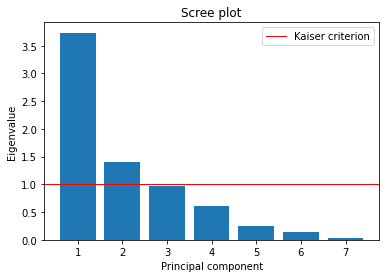

Number of principal components above Kaiser criterion: 2


In [4]:
# QUESTION 3

from scipy import stats
from sklearn.decomposition import PCA

num_features = df.shape[1]

# do PCA since data already z-scored
pca = PCA(random_state=1).fit(df)
# find eigenvalues
eigVals = pca.explained_variance_
# get loadings
loadings = pca.components_ *-1
# rotate data to new coordinate system
rotatedData = pca.fit_transform(df) *-1

# scree plot
plt.bar(np.linspace(1,num_features,num_features),eigVals)
plt.xlabel('Principal component')
plt.ylabel('Eigenvalue')
plt.title('Scree plot')
plt.plot([0,7.75],[1,1],color='red',linewidth=1,label="Kaiser criterion") # Kaiser criterion line
plt.legend()
plt.xlim([0.25,7.75])
plt.savefig('scree.jpg')
plt.show()

# number of principal components above the Kaiser criterion line
num_interp_comps = eigVals[eigVals > 1].size
print("Number of principal components above Kaiser criterion: " + str(num_interp_comps))

### Interpreting Principal Components
Though the principal components are difficult to interpret, we can surmise the following:

1. Low cases/deaths, not much activity, low GDP
2. Sparsely populated, unhealthy

In [5]:
import copy

# interpreting the components
for comp in range(num_interp_comps):
    print("Component: " + str(comp+1))
    toward = copy.deepcopy(loadings[comp,:])
    away = copy.deepcopy(loadings[comp,:])
    toward[toward < 0] = 0
    away[away > 0] = 0
    sorted_toward_idx = np.argsort(toward)
    sorted_away_idx = np.argsort(away)
    print("Points towards:")
    print(list(df.columns[sorted_toward_idx]))
    print(toward[sorted_toward_idx])
    print()
    print("Points away:")
    print(list(df.columns[sorted_away_idx]))
    print(away[sorted_away_idx])
    print()
    print()

Component: 1
Points towards:
['GDPs', 'Total Cases', 'Total Death', 'Day lockdown', 'Population density', 'Busy airport score', 'Health']
[0.         0.         0.         0.         0.         0.
 0.11788629]

Points away:
['Total Cases', 'Total Death', 'Busy airport score', 'GDPs', 'Population density', 'Day lockdown', 'Health']
[-0.49865751 -0.46266325 -0.45404    -0.42604508 -0.33599045 -0.15109571
  0.        ]


Component: 2
Points towards:
['Health', 'Total Cases', 'Total Death', 'Population density', 'Day lockdown', 'Busy airport score', 'GDPs']
[0.         0.         0.         0.         0.14255182 0.27027089
 0.31304487]

Points away:
['Health', 'Population density', 'Total Death', 'Total Cases', 'GDPs', 'Day lockdown', 'Busy airport score']
[-0.67774686 -0.50999397 -0.27380465 -0.11929752  0.          0.
  0.        ]




Clustering

Optimal number of clusters: 2


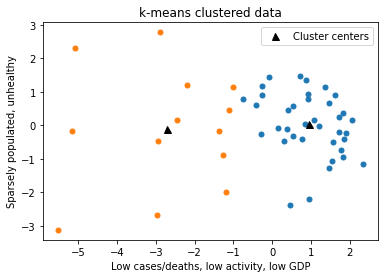

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples

# get rotated data
X = rotatedData[:,:num_interp_comps]

# silhouette method:
numClusters = 10
Q = np.empty([numClusters,1])

for ii in range(2, 2+numClusters):
    kMeans = KMeans(n_clusters = int(ii)).fit(X)
    cId = kMeans.labels_
    s = silhouette_samples(X,cId)
    Q[ii-2] = sum(s)

# optimal number of clusters
optimal_clusters = np.argmax(Q) + 2
# perform kMeans
kMeans = KMeans(n_clusters = optimal_clusters).fit(X)
# cluster ID for each state
cId = kMeans.labels_
# coordinates for each cluster center
cCoords = kMeans.cluster_centers_

print("Optimal number of clusters: " + str(optimal_clusters))

plt.clf()

comp1 = "Low cases/deaths, low activity, low GDP"
comp2 = "Sparsely populated, unhealthy"

# plot color-coded k-means clusters
indexVector = np.linspace(1,len(np.unique(cId)),len(np.unique(cId)))
for ii in indexVector:
    plotIndex = np.argwhere(cId == int(ii-1))
    plt.plot(rotatedData[plotIndex,0],rotatedData[plotIndex,1],'o',markersize=5)
    plt.plot(cCoords[int(ii-1),0],cCoords[int(ii-1),1],'^',markersize=7,color='black')  
plt.xlabel(comp1)
plt.ylabel(comp2)
plt.title("k-means clustered data")
plt.plot([],[],'^',markersize=7,color='black',label="Cluster centers")  
plt.legend()
plt.savefig('clusters.jpg')
plt.show()